Importing python libraries

In [ ]:
import numpy as np
from scipy.stats import iqr
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
from nilearn.plotting import plot_connectome
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
plt.ion()

Initialize variables

In [2]:
n_jobs = -1
n_sources = 98 
n_permutations = 1000

subject_number = 1
inputdir = 'data/'
filename_template = 'subject_%s_covariance_source.npz'

Import data

In [ ]:
data = np.load(inputdir + filename_template % (subject_number), allow_pickle=True)
Xs = data['x']
ys = data['y']

Extract the lower diagonal of the covariance matrix

In [ ]:
covidx = np.tril_indices(n_sources,k=-1)
Ds = np.array([Xs[ii][covidx] for ii in range(len(Xs))])

Training the logistic regression model on the lower diagonal of the spatial covariance matrix (note that the Riemannian kernel transformation is not allowed in this case)

In [ ]:
clf = LogisticRegression(solver='lbfgs', C=0.01, max_iter=10000, tol=1.0e-3)
model = clf.fit(Ds, ys)
model.score(Ds, ys)

Computing the predictability of each class for all input features connections by looking at the coefficient weights. In this binary classification scenario, we estimate whether any connection is predictive for either face or place imagery decoding. In particular, positive odds stand for connections predictive for face imagery (similar to class A), while negative odds stand for connections predictive for place imagery (different from class A).

In [ ]:
coefficients = model.coef_
face_features = np.clip(coefficients,a_min=0,a_max=None)
place_features = np.clip(coefficients,a_min=None,a_max=0)

Computing the most important features using permutation feature invariance. Selecting connections by feature importance from the 99% percentile.  

In [3]:
print(' ')
print('permutation feature importance')

imp = permutation_importance(model, Ds, ys, n_repeats=n_permutations, random_state=0, scoring='roc_auc', n_jobs=n_jobs)
threshold = iqr(np.abs(imp['importances_mean'][np.nonzero(imp['importances_mean'])[0]]),rng=(1,99))
mask = np.abs(imp['importances_mean']) > threshold

face_feature_matrix = np.zeros((n_sources,n_sources))
face_feature_matrix[covidx] = face_features * mask
face_feature_matrix.T[covidx] = face_features * mask
place_feature_matrix = np.zeros((n_sources,n_sources))
place_feature_matrix[covidx] = place_features * mask
place_feature_matrix.T[covidx] = place_features * mask

beta_coefs = face_feature_matrix - np.abs(place_feature_matrix)

 
permutation feature importance


Loading information about label names, positions and colors for each region of interest in the Glasser et al. atlas.

In [20]:
atlas = np.load(inputdir + 'atlas_labels.npz', allow_pickle=True)
labelnames = atlas['names']
labelpos = atlas['pos']
labelcolors = atlas['colors']

Plotting results on a glass brain and a connectivity matrix for each hemisphere.

Text(0.5, 1.0, 'right hemisphere')

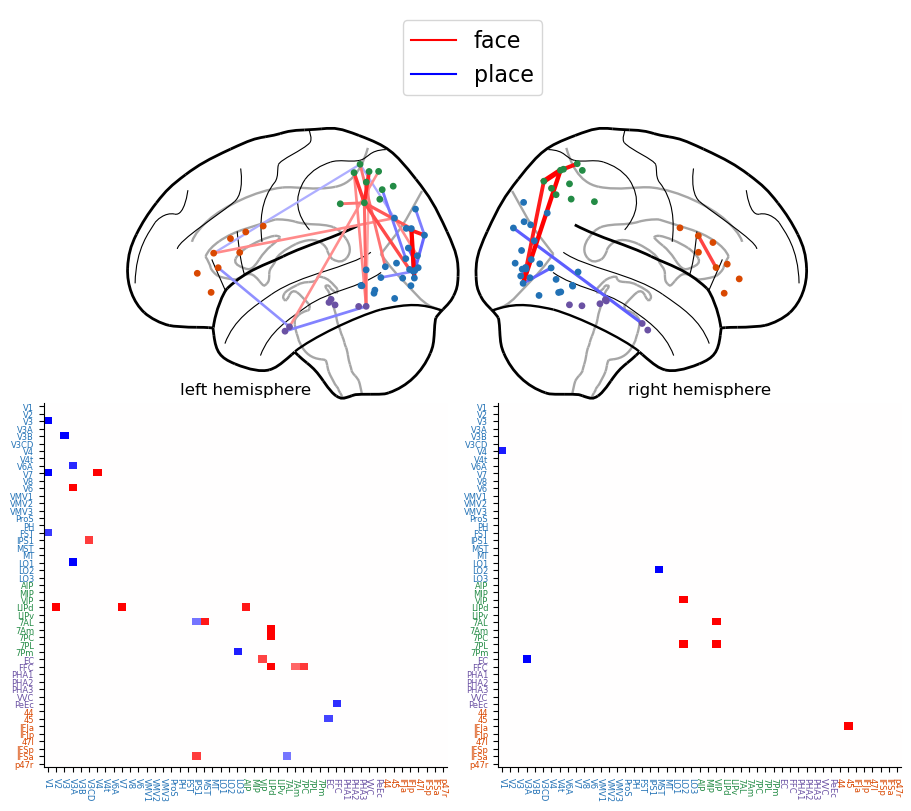

In [26]:
fig = plt.figure(figsize=(9,8), constrained_layout=True)
gs = GridSpec(2, 2, height_ratios=[1.0, 1.0], hspace=-0.1, wspace=-0.1, figure=fig)

ax_top = fig.add_subplot(gs[0, :])
plot_connectome(beta_coefs, np.array(labelpos), edge_threshold=None, edge_vmin=-0.05, edge_vmax=0.05, node_color=labelcolors,
				title=None, edge_cmap='bwr', figure=fig, axes=ax_top, display_mode='lr', node_size=15, alpha=1.0, colorbar=False)
face_line = Line2D([0], [0], color='red', linestyle='-', label='face')
place_line = Line2D([0], [0], color='blue', linestyle='-', label='place')
ax_top.legend(handles=[face_line, place_line], loc=9, fontsize=16)

left_sub = np.tril(beta_coefs[:49,:49])

ax_bottom_left = fig.add_subplot(gs[1, 0])
ax_bottom_left.imshow(left_sub, aspect='auto',vmin=-0.03, vmax=0.03, cmap='bwr')
ax_bottom_left.set_xticks(np.arange(49),labelnames[:49],rotation=270)
for tick_label, color in zip(ax_bottom_left.get_xticklabels(), labelcolors[:49]):
    tick_label.set_color(color)
ax_bottom_left.set_yticks(np.arange(49),labelnames[:49])
for tick_label, color in zip(ax_bottom_left.get_yticklabels(), labelcolors[:49]):
    tick_label.set_color(color)
ax_bottom_left.tick_params(labelsize=6)
ax_bottom_left.spines['right'].set_visible(False)
ax_bottom_left.spines['top'].set_visible(False)
ax_bottom_left.yaxis.set_ticks_position('left')
ax_bottom_left.xaxis.set_ticks_position('bottom')
ax_bottom_left.set_title('left hemisphere')

right_sub = np.tril(beta_coefs[49:,49:])

ax_bottom_right = fig.add_subplot(gs[1, 1])
ax_bottom_right.imshow(right_sub, aspect='auto', vmin=-0.03, vmax=0.03, cmap='bwr')
ax_bottom_right.set_xticks(np.arange(49),labelnames[49:],rotation=270)
for tick_label, color in zip(ax_bottom_right.get_xticklabels(), labelcolors[49:]):
    tick_label.set_color(color)
ax_bottom_right.set_yticks(np.arange(49),labelnames[49:])
for tick_label, color in zip(ax_bottom_right.get_yticklabels(), labelcolors[:49]):
    tick_label.set_color(color)
ax_bottom_right.tick_params(labelsize=6)
ax_bottom_right.spines['right'].set_visible(False)
ax_bottom_right.spines['top'].set_visible(False)
ax_bottom_right.yaxis.set_ticks_position('left')
ax_bottom_right.xaxis.set_ticks_position('bottom')
ax_bottom_right.set_title('right hemisphere')